In [1]:
import matplotlib
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.naive_bayes import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from re import sub
def mdy_to_ymd(d):
    return time.mktime(datetime.strptime(d, '%d-%b-%y').timetuple())

class Beautify:

    @staticmethod
    def beautify(path):
        dataset = pd.read_csv(path)
        dataset.columns = ["date", "price", "open", "high", "low", "vol", "change"]
        dataset["date"] = dataset.apply(lambda row: mdy_to_ymd(row['date']), axis=1)
        for col in ["price", "open", "high", "low", "vol", "change"]:
            dataset[col] = dataset.apply(
                lambda row: (lambda x: 0 if x == '-' else float(x))(sub(r'[^\d.-]', '', row[col])),
                axis=1)
        dataset = dataset.sort_values(["date"])
        return dataset


pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [2]:
dataset = Beautify.beautify("dataset.csv")[["date","price","change"]].reset_index(drop=True)
dataset["change"] = dataset.apply(lambda x: -1 if x["change"] <= 0 else 1,axis=1)

<AxesSubplot:>

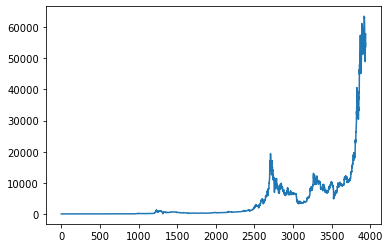

In [3]:
dataset["price"].plot()

In [4]:
TRAIN = time.mktime(datetime.strptime("20-01-02", '%y-%m-%d').timetuple())
train = dataset[dataset.date < TRAIN]
test = dataset[dataset.date >= TRAIN]

In [5]:
trend_removed = train[["price","change"]]

In [6]:
n_bins = 45
bins = np.linspace(trend_removed["price"].min(), trend_removed["price"].max(), n_bins)
binned = np.digitize(trend_removed["price"], bins)

binned_series = pd.Series(binned, index = trend_removed.index)

In [7]:
bin_means = {}

for binn in range(1,n_bins+1):
    bin_means[binn] = trend_removed[binned == binn].mean()

In [8]:
lagged_list = []
for s in range(13):
    lagged_list.append(binned_series.shift(s))
    
lagged_frame = pd.concat(lagged_list,1).dropna()

train_X = lagged_frame.iloc[:,1:]
train_y = lagged_frame.iloc[:,0]
train_X["change"] = train["change"]

In [9]:
def get_mean_from_class(prediction):
    return(bin_means[prediction[0]])

In [10]:
model = KNeighborsClassifier()

In [11]:
model.fit(train_X, train_y)

KNeighborsClassifier()

In [21]:
pred_insample = model.predict(train_X)
pred_insample = pd.DataFrame(pred_insample, index = train_y.index)
resulting_prediction = pd.Series(np.nan, index = train_y.index)
for row in range(len(pred_insample)):
    resulting_prediction.iloc[row] = bin_means[pred_insample.values[row][0]].price

12      124
13      124
14      124
15      124
16      124
       ... 
3450   7275
3451   7275
3452   7275
3453   7275
3454   7275
Length: 3443, dtype: float64

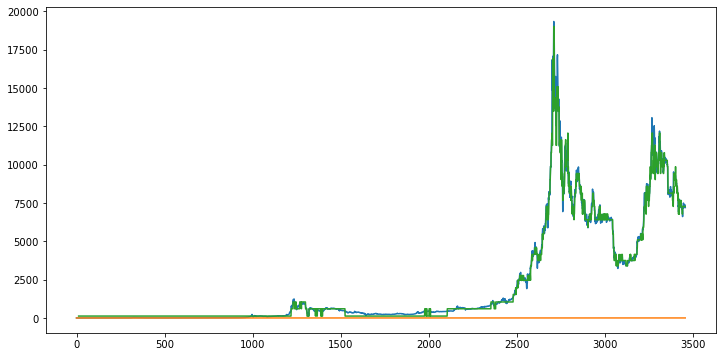

In [22]:
plt.figure(figsize = (12,6))
plt.plot(trend_removed)
plt.plot(resulting_prediction)
resulting_prediction

In [29]:
bins = np.linspace(test["price"].min(), test["price"].max(), n_bins)
binned = np.digitize(test["price"], bins)

binned_series = pd.Series(binned, index = test.index)
bin_means = {}

for binn in range(1,n_bins+1):
    bin_means[binn] = test[binned == binn].mean()

In [30]:
lagged_list = []
for s in range(13):
    lagged_list.append(binned_series.shift(s))
    
lagged_frame = pd.concat(lagged_list,1).dropna()

test_X = lagged_frame.iloc[:,1:]
test_y = lagged_frame.iloc[:,0]
test_X["change"] = test["change"]

In [31]:
pred_insample = model.predict(test_X)
pred_insample = pd.DataFrame(pred_insample, index = test_y.index)
resulting_prediction = pd.Series(np.nan, index = test_y.index)

In [32]:
pred_insample.values.reshape(1,-1)

array([[ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         4,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  4,  5,
         4,  5,  4,  5,  4,  4,  4,  4,  5,  4,  4,  4,  4,  4,  4,  3,
         4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  2,  2,  2,
         2,  2,  2,  1,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  5,  4,  4,  4,  4,  4,  5,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  5,  4,  5,  5,  6,  5,  5,  5,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 

In [33]:
res = pd.DataFrame({"pred":pred_insample.values.reshape(1,-1)[0],"real":test_y.to_numpy()})

In [34]:
res["pred"] = res.apply(lambda x: bin_means[x["pred"]]["price"],axis=1)
res["real"] = res.apply(lambda x: bin_means[x["real"]]["price"],axis=1)

In [35]:
from sklearn.metrics import mean_squared_error
res = res[~res.pred.isna()]
mean_squared_error(res.real,res.pred)


14852064.455555504

In [36]:
res[(res.pred >= res.real*0.95) & (res.pred <= res.real*1.05)].shape[0]/res.shape[0] * 100

53.304904051172706